# Visualizing SARIMA vs Chronos 2 on Augmented Traffic

Let's visualize the forecasts on a few sample sectors from our newly augmented (smoothed IPP) dataset. 
We will compare the baseline SARIMA approach with the zero-shot Chronos 2 model.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings

from src.evaluate import calculate_metrics
from src.models.sarima_wrapper import get_sarima_forecast
from src.models.chronos_wrapper import get_chronos_forecast
from chronos import ChronosPipeline

warnings.filterwarnings('ignore')

# Load the smoothed augmented dataset
print("Loading augmented dataset...")
df = pd.read_csv("data/augmented_data.csv")
df["tstamp"] = pd.to_datetime(df["tstamp"])


Loading augmented dataset...


In [2]:
# Pre-load Chronos Pipeline to avoid reloading Model Weights
print("Loading Chronos 2 Pipeline...")
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.float32,
)


Loading Chronos 2 Pipeline...


`torch_dtype` is deprecated! Use `dtype` instead!


Sector: T78273B
  SARIMA RMSE: 19.3243
  Chronos RMSE: 17.1110

Sector: T36870A
  SARIMA RMSE: 7.4657
  Chronos RMSE: 7.7245

Sector: T78270C
  SARIMA RMSE: 8.8660
  Chronos RMSE: 4.9449



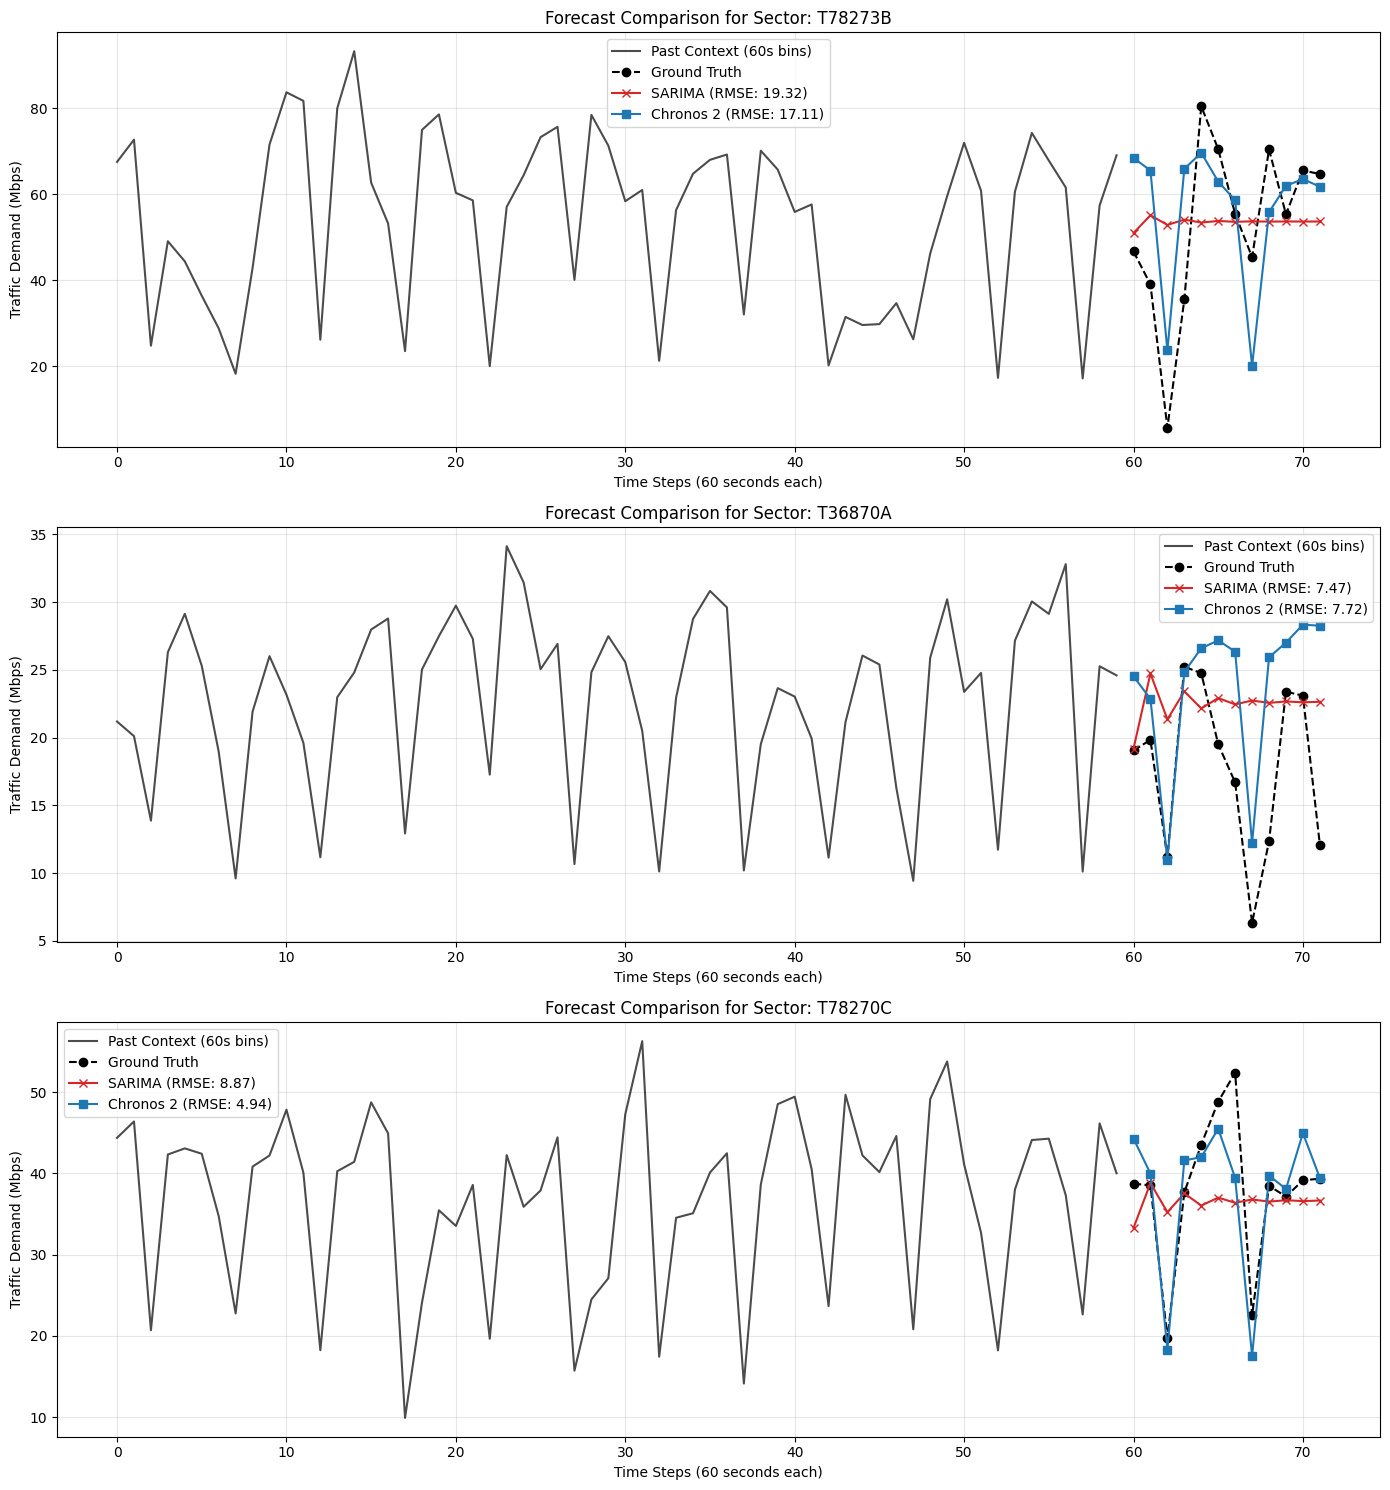

In [3]:
# Select 3 random sectors for visualization
np.random.seed(42)
sectors = df["secteur"].unique()
sample_sectors = np.random.choice(sectors, 3, replace=False)

context_length = 60
pred_length = 12

fig, axes = plt.subplots(len(sample_sectors), 1, figsize=(14, 5 * len(sample_sectors)))
if len(sample_sectors) == 1:
    axes = [axes]

for i, sector in enumerate(sample_sectors):
    sector_df = df[df["secteur"] == sector].sort_values("tstamp")
    series = sector_df["trafic_mbps"].to_numpy()
    
    # We predict the last 12 points based on the previous 60 points
    actual = series[-pred_length:]
    history = series[-(context_length + pred_length):-pred_length]
    
    # 1. SARIMA Baseline Forecast
    sarima_pred = get_sarima_forecast(history, pred_length)
    
    # 2. Chronos 2 Forecast
    history_tensor = torch.tensor(history, dtype=torch.float32).unsqueeze(0)
    chronos_pred_batch = get_chronos_forecast(
        history_tensor, 
        pred_length=pred_length, 
        model_id="amazon/chronos-t5-small", 
        pipeline=pipeline
    )
    chronos_pred = chronos_pred_batch[0]
    
    # Calculate RMSE
    sarima_metrics = calculate_metrics(actual, sarima_pred)
    chronos_metrics = calculate_metrics(actual, chronos_pred)
    
    print(f"Sector: {sector}")
    print(f"  SARIMA RMSE: {sarima_metrics['RMSE']:.4f}")
    print(f"  Chronos RMSE: {chronos_metrics['RMSE']:.4f}\n")
    
    # Plotting
    ax = axes[i]
    x_context = np.arange(context_length)
    x_pred = np.arange(context_length, context_length + pred_length)
    
    # Plot past context
    ax.plot(x_context, history, label="Past Context (60s bins)", color='black', alpha=0.7)
    
    # Plot Ground Truth
    ax.plot(x_pred, actual, label="Ground Truth", linestyle='--', color='black', marker='o')
    
    # Plot Predictions
    ax.plot(x_pred, sarima_pred, label=f"SARIMA (RMSE: {sarima_metrics['RMSE']:.2f})", color='tab:red', marker='x')
    ax.plot(x_pred, chronos_pred, label=f"Chronos 2 (RMSE: {chronos_metrics['RMSE']:.2f})", color='tab:blue', marker='s')
    
    ax.set_title(f"Forecast Comparison for Sector: {sector}")
    ax.set_xlabel("Time Steps (60 seconds each)")
    ax.set_ylabel("Traffic Demand (Mbps)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
